<a href="https://colab.research.google.com/github/psong5/Twitter-Hate-Speech-Detection-Using-Various-Machine-Learning-Models/blob/main/original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#this is for the preprocessing steps
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

url = 'https://raw.githubusercontent.com/sidneykung/twitter_hate_speech_detection/master/src/twitter_data.csv'
df = pd.read_csv(url)
df.head()

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
#preprocessing
x = df[['tweet']]
print(x)

y = df[['class']] # 0: hate, 1: offensive, 2: neither
print(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
import re
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in string.punctuation and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

X_train_preprocessed = [preprocess_text(text) for text in X_train['tweet']]
X_test_preprocessed = [preprocess_text(text) for text in X_test['tweet']]
print (len(X_train_preprocessed))
print (len(y_train))
pd.DataFrame(X_train_preprocessed).to_csv('/content/drive/My Drive/X_train_neural.csv')
pd.DataFrame(X_test_preprocessed).to_csv('/content/drive/My Drive/X_test_neural.csv')
pd.DataFrame(y_train).to_csv('/content/drive/My Drive/y_train_neural.csv')
pd.DataFrame(y_test).to_csv('/content/drive/My Drive/y_test_neural.csv')

# Convert tokenized sentences into Word2Vec model
w2v_model = Word2Vec(sentences=X_train_preprocessed, vector_size=100, window=5, min_count=5, workers=4)

def vectorize(sentence):
    words_vecs = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]
    if len(words_vecs) == 0:
      return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train_preprocessed])
X_test = np.array([vectorize(sentence) for sentence in X_test_preprocessed])
print(len(X_train))
print(len(y_train))
#filter out zeros
non_zero_indices = np.all(X_train != 0, axis=1)
X_train = X_train[non_zero_indices]
y_train = y_train[non_zero_indices]

# Filter out zero vectors from X_test
non_zero_indices = np.all(X_test != 0, axis=1)
X_test = X_test[non_zero_indices]
y_test = y_test[non_zero_indices]
print(len(X_train))
print(len(y_train))

np.savetxt('/content/drive/My Drive/X_train.csv', X_train, delimiter=',')
np.savetxt('/content/drive/My Drive/X_test.csv', X_test, delimiter=',')
np.savetxt('/content/drive/My Drive/y_train.csv', y_train, delimiter=',')
np.savetxt('/content/drive/My Drive/y_test.csv', y_test, delimiter=',')





                                                   tweet
0      !!! RT @mayasolovely: As a woman you shouldn't...
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...                                                  ...
24778  you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779  you've gone and broke the wrong heart baby, an...
24780  young buck wanna eat!!.. dat nigguh like I ain...
24781              youu got wild bitches tellin you lies
24782  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...

[24783 rows x 1 columns]
       class
0          2
1          1
2          1
3          1
4          1
...      ...
24778      1
24779      2
24780      1
24781      1
24782      2

[24783 rows x 1 columns]
19826
19826
19826
19826
19802
19802


In [ ]:
print (len(X_test))
print (len(y_test))

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))

4951
4951


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8511411835992728
Precision: 0.7998171015452701
Recall: 0.8511411835992728
F1 score: 0.8239635639375623


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1    0.772899
2    0.168963
0    0.058138
Name: class, dtype: float64


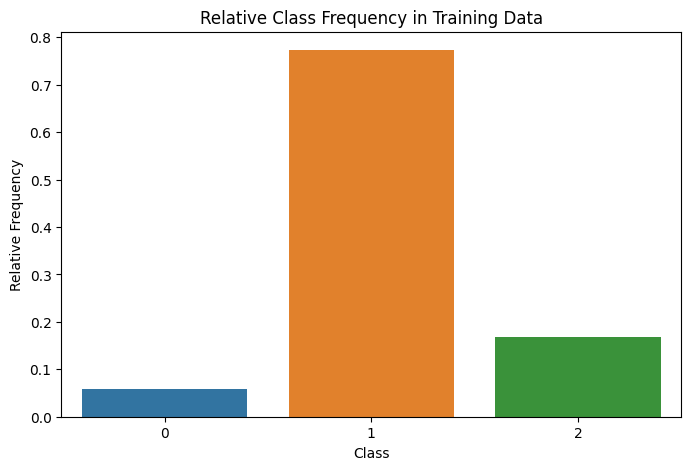

In [ ]:
# Create bar graph for the y_train values
class_counts = y_train['class'].value_counts()
total_samples = len(y_train)
relative_frequencies = class_counts / total_samples
print(relative_frequencies)

plt.figure(figsize=(8, 5))
sns.barplot(x=relative_frequencies.index, y=relative_frequencies.values)
plt.xlabel('Class')
plt.ylabel('Relative Frequency')
plt.title('Relative Class Frequency in Training Data')
plt.show()



1    0.774321
2    0.167978
0    0.057701
Name: class, dtype: float64


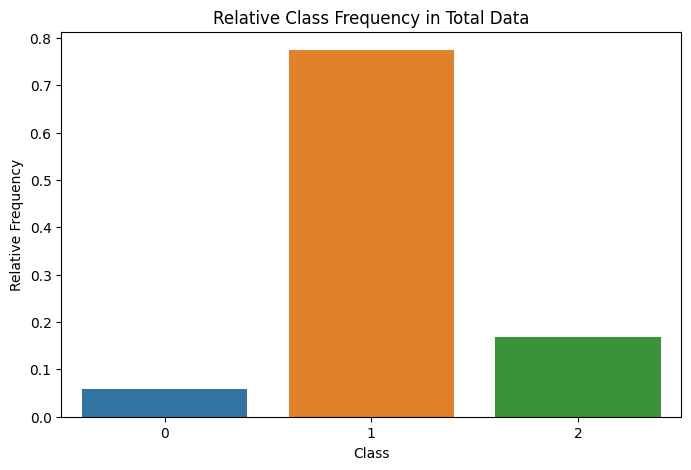

In [ ]:
# Create bar graph for the entire y dataset
total_counts = y['class'].value_counts()
total = len(y)
relative_frequencies = total_counts / total

print(relative_frequencies)

plt.figure(figsize=(8, 5))
sns.barplot(x=relative_frequencies.index, y=relative_frequencies.values)
plt.xlabel('Class')
plt.ylabel('Relative Frequency')
plt.title('Relative Class Frequency in Total Data')
plt.show()